Saving animation to three_body_simulation.mp4...
Animation saved.


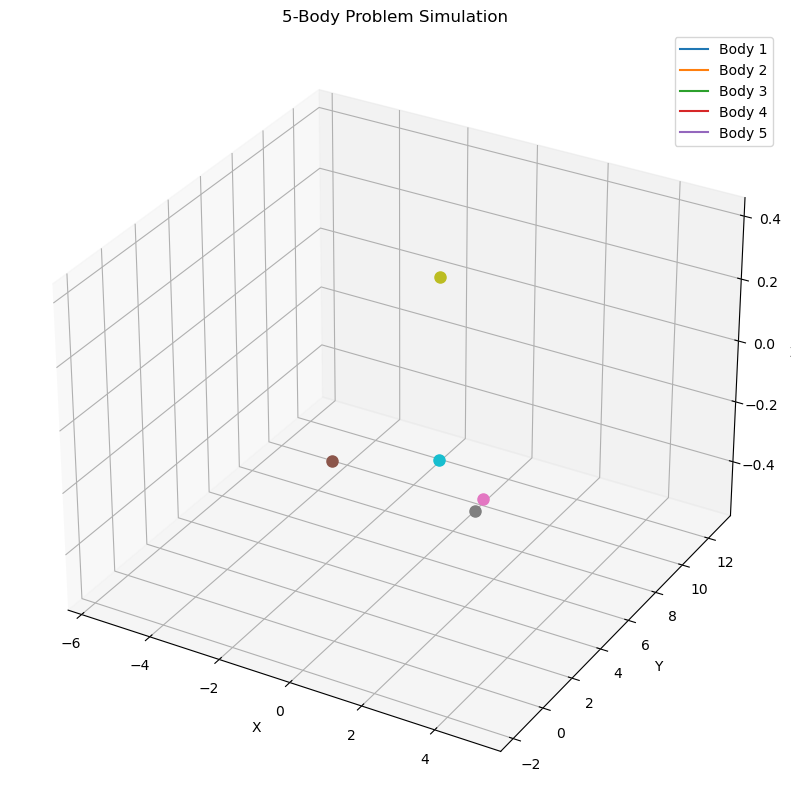

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def n_body_equations(w, t, G, masses):
    """
    Defines the differential equations for the N-body problem.
    
    Arguments:
        w :  vector of the state variables:
             w = [x1, y1, z1, ..., xN, yN, zN, vx1, vy1, vz1, ..., vxN, vyN, vzN]
        t :  time
        G :  gravitational constant
        masses : list or array of masses for the N bodies
    """
    N = len(masses)
    r = w[:3*N].reshape((N, 3))
    v = w[3*N:].reshape((N, 3))

    dvdt = np.zeros((N, 3))
    drdt = v

    for i in range(N):
        for j in range(N):
            if i != j:
                r_ij = r[j] - r[i]
                dist = np.linalg.norm(r_ij)
                dvdt[i] += G * masses[j] * r_ij / dist**3

    return np.concatenate((drdt.flatten(), dvdt.flatten()))

def run_simulation():
    # Constants
    G = 1.0  # Gravitational constant (normalized)
    
    # Define N bodies
    # Masses: Central massive body + 4 smaller bodies
    m_center = 10.0
    m_small = 0.5
    masses = np.array([m_center, m_small, m_small, m_small, m_small])
    N = len(masses)

    # Initial conditions
    r = np.zeros((N, 3))
    v = np.zeros((N, 3))

    # 1. Central Body
    r[0] = [0, 0, 0]
    v[0] = [0, 0, 0]

    # Helper function for circular orbit velocity
    def orbital_velocity(pos, central_mass, G=1.0):
        r_mag = np.linalg.norm(pos)
        v_mag = np.sqrt(G * central_mass / r_mag)
        # Velocity perpendicular to position (in xy plane for simplicity)
        # v = omega x r, where omega is along z
        return np.array([-v_mag * pos[1] / r_mag, v_mag * pos[0] / r_mag, 0])

    # 2. First Binary Pair (Bodies 1 and 2)
    # Center of mass of the pair orbits the central body
    dist_pair1 = 4.0
    pos_pair1_cm = np.array([dist_pair1, 0, 0])
    vel_pair1_cm = orbital_velocity(pos_pair1_cm, m_center)

    # Separation within pair
    sep_pair1 = 0.5
    # Relative positions
    r[1] = pos_pair1_cm + np.array([0, sep_pair1/2, 0])
    r[2] = pos_pair1_cm - np.array([0, sep_pair1/2, 0])
    
    # Relative velocity for circular orbit around pair CM
    # v_rel^2 = G * (m1+m2) / sep
    v_rel_mag = np.sqrt(G * (m_small + m_small) / sep_pair1)
    # Perpendicular to separation (along x in this local frame)
    v_rel_vec = np.array([v_rel_mag, 0, 0])
    
    v[1] = vel_pair1_cm - v_rel_vec/2
    v[2] = vel_pair1_cm + v_rel_vec/2

    # 3. Second Binary Pair (Bodies 3 and 4)
    # Orbiting at a different distance/angle
    dist_pair2 = 7.0
    angle_pair2 = np.pi / 2 # 90 degrees
    pos_pair2_cm = np.array([dist_pair2 * np.cos(angle_pair2), dist_pair2 * np.sin(angle_pair2), 0])
    vel_pair2_cm = orbital_velocity(pos_pair2_cm, m_center)

    # Separation within pair
    sep_pair2 = 0.6
    # Relative positions (tilted slightly out of plane for variety)
    r[3] = pos_pair2_cm + np.array([0, 0, sep_pair2/2])
    r[4] = pos_pair2_cm - np.array([0, 0, sep_pair2/2])

    # Relative velocity
    v_rel_mag2 = np.sqrt(G * (m_small + m_small) / sep_pair2)
    # Perpendicular to separation (along x/y depending on orientation)
    # Here separation is along z, so velocity can be in xy plane
    # Let's make it orbit around the radial vector from center
    radial_vec = pos_pair2_cm / np.linalg.norm(pos_pair2_cm)
    v_rel_vec2 = np.cross(np.array([0,0,1]), radial_vec) * v_rel_mag2 # This is tangential to main orbit, wait.
    # Actually, let's just make them orbit each other in the plane perpendicular to the radius
    v_rel_vec2 = np.array([v_rel_mag2 * np.cos(angle_pair2), v_rel_mag2 * np.sin(angle_pair2), 0]) # Tangential

    v[3] = vel_pair2_cm - v_rel_vec2/2
    v[4] = vel_pair2_cm + v_rel_vec2/2

    # Add small random perturbations to avoid perfect symmetry and numerical issues
    r += np.random.uniform(-0.01, 0.01, (N, 3))
    v += np.random.uniform(-0.005, 0.005, (N, 3))

    # Initial state vector
    w0 = np.concatenate((r.flatten(), v.flatten()))

    # Time array - High resolution
    t = np.linspace(0, 30, 6000)

    # Solve ODE
    w = odeint(n_body_equations, w0, t, args=(G, masses))

    # Extract solutions
    r_sol = w[:, :3*N].reshape((len(t), N, 3))

    # Plotting
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Initialize lines and points
    lines = [ax.plot([], [], [], label=f'Body {i+1}')[0] for i in range(N)]
    points = [ax.plot([], [], [], 'o', markersize=8)[0] for i in range(N)]

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{N}-Body Problem Simulation')
    ax.legend()
    
    # Set limits based on trajectory
    all_x = r_sol[:, :, 0].flatten()
    all_y = r_sol[:, :, 1].flatten()
    all_z = r_sol[:, :, 2].flatten()
    
    ax.set_xlim(all_x.min(), all_x.max())
    ax.set_ylim(all_y.min(), all_y.max())
    ax.set_zlim(all_z.min(), all_z.max())

    def update(frame):
        for i in range(N):
            # Update lines (history)
            lines[i].set_data(r_sol[:frame, i, 0], r_sol[:frame, i, 1])
            lines[i].set_3d_properties(r_sol[:frame, i, 2])
            
            # Update points (current position)
            points[i].set_data([r_sol[frame, i, 0]], [r_sol[frame, i, 1]])
            points[i].set_3d_properties([r_sol[frame, i, 2]])
        
        return lines + points

    # Create animation
    # Skip frames to make it faster if needed
    skip = 10 # Increased skip because we have more time steps
    frames = range(0, len(t), skip)
    ani = FuncAnimation(fig, update, frames=frames, interval=20, blit=False)

    output_file = 'three_body_simulation.mp4'
    print(f"Saving animation to {output_file}...")
    ani.save(output_file, writer='ffmpeg', fps=30)
    print("Animation saved.")
    
    # plt.show() # Commented out to avoid blocking if running headless or just saving

if __name__ == "__main__":
    run_simulation()
